# Complex System Simulation

Complex river networks with cellular automata


In [1]:
import numpy as np
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt

The following cell contains the class we created to simulate the rivers

In [2]:
class CA:
    """
    parameters:
    
    - size:         size of grid (square grid of size x size)
    - slope:        slope of the grid, slope from row to row
    - time_limit:   maximum number of time steps
    - rand_lower:   lower bound of randomly generated number
    - rand_upper:   upper bound of randomly generated number
    - branch_tresh: branching threshold
    - init_water:   initial water level
    - delta_water:  water loss variable, loss per step
    
    """
    
    
    def __init__(
        self, size, slope, time_limit, rand_lower=0.9999, rand_upper=1.00001,
        branch_tresh=0.1, init_water=1, delta_water=0.0008, viz=False
    ):
        self.size = size
        self.slope = slope
        self.time_limit = time_limit
        self.rand_lower = rand_lower
        self.rand_upper = rand_upper
        self.branch_tresh = branch_tresh
        self.init_water_level = init_water
        self.delta_w = delta_water
        
        # starting point / source cell in the middle of the grid
        self.starting_column = int(self.size / 2)
        
        self.terrain = np.zeros((size, size))
        self.cur_river_nr = 1
        self.rivers = {}

        self.path = np.zeros((size, size))
        
        self.river_coors = set()
        self.split_dict = {}
        self.segment_dict = {}
        self.segment_grid = self.path.copy()
        self.viz = viz
        if self.viz:
            self.path_list = []

    def moore_neighborhood(self, grid, i, j):
        """
        Function returning the Moore neigborhood of a given cell 
        
        Also returns the grid coordinates of all the individual neighbors
        """

        if i == 0 and j == 0:
            neighborhood = [
                grid[i + 1, j + 1],
                grid[i, j + 1],
                grid[i + 1, j],
            ]
            locations = [
                [i + 1, j + 1],
                [i, j + 1],
                [i + 1, j]
            ]

        elif i == 0 and j == (self.size - 1):
            neighborhood = [
                grid[i, j - 1],
                grid[i + 1, j - 1],
                grid[i + 1, j],
            ]
            locations = [
                [i, j - 1],
                [i + 1, j - 1],
                [i + 1, j],
            ]

        elif i == 0 and 0 < j < (self.size - 1):
            neighborhood = [
                grid[i, j - 1],
                grid[i, j + 1],
                grid[i + 1, j - 1],
                grid[i + 1, j],
                grid[i + 1, j + 1],
            ]
            locations = [
                [i, j - 1],
                [i, j + 1],
                [i + 1, j - 1],
                [i + 1, j],
                [i + 1, j + 1],
            ]

        elif i == (self.size - 1) and j == 0:
            neighborhood = [
                grid[i, j + 1],
                grid[i - 1, j + 1],
                grid[i - 1, j],
            ]
            locations = [
                [i, j + 1],
                [i - 1, j + 1],
                [i - 1, j],
            ]

        elif i == (self.size - 1) and j == (self.size - 1):
            neighborhood = [
                grid[i - 1, j - 1],
                grid[i, j - 1],
                grid[i - 1, j],
            ]
            locations = [
                [i - 1, j - 1],
                [i, j - 1],
                [i - 1, j],
            ]

        elif i == (self.size - 1) and 0 < j < (self.size - 1):
            neighborhood = [
                grid[i, j - 1],
                grid[i, j + 1],
                grid[i - 1, j - 1],
                grid[i - 1, j],
                grid[i - 1, j + 1],
            ]
            locations = [
                [i, j - 1],
                [i, j + 1],
                [i - 1, j - 1],
                [i - 1, j],
                [i - 1, j + 1],
            ]

        elif 0 < i < (self.size - 1) and j == 0:
            neighborhood = [
                grid[i - 1, j],
                grid[i - 1, j + 1],
                grid[i, j + 1],
                grid[i + 1, j],
                grid[i + 1, j + 1],
            ]
            locations = [
                [i - 1, j],
                [i - 1, j + 1],
                [i, j + 1],
                [i + 1, j],
                [i + 1, j + 1],
            ]

        elif 0 < i < (self.size - 1) and j == (self.size - 1):
            neighborhood = [
                grid[i - 1, j],
                grid[i - 1, j - 1],
                grid[i, j - 1],
                grid[i + 1, j],
                grid[i + 1, j - 1],
            ]
            locations = [
                [i - 1, j],
                [i - 1, j - 1],
                [i, j - 1],
                [i + 1, j],
                [i + 1, j - 1],
            ]

        else:
            neighborhood = [
                grid[i - 1, j - 1],
                grid[i - 1, j],
                grid[i - 1, j + 1],
                grid[i, j - 1],
                grid[i, j + 1],
                grid[i + 1, j - 1],
                grid[i + 1, j],
                grid[i + 1, j + 1],
            ]
            locations = [
                [i - 1, j - 1],
                [i - 1, j],
                [i - 1, j + 1],
                [i, j - 1],
                [i, j + 1],
                [i + 1, j - 1],
                [i + 1, j],
                [i + 1, j + 1],
            ]

        return neighborhood, locations

    def initialize_terrain(self):
        """
        Function creating the sloping terrain including random perturbations with respect to neighbors
        
        Additionally, evelavations in the terrain can be created (referred to as hills)
        
        """
        
        # terrain is initialized as a size x size grid with equal height
        terrain = np.ones((self.size, self.size))

        # turn into sloping terrain
        for i in range(self.size - 1):
            terrain[i + 1] = terrain[i] * (1 - self.slope)

        # incorporate randomness in terrain
        for i in range(self.size):
            for j in range(self.size):
                neighbors = self.moore_neighborhood(terrain, i, j)[0]
                if rd.random() < 0.01:
                    perturb = rd.uniform(0.999, 1.0001)
                else:
                    perturb = rd.uniform(self.rand_lower, self.rand_upper)
                terrain[i, j] = np.mean(neighbors) * perturb

        # enter the coordinates, commented coordinates were used on a 200 x 200 grid
        hill_coords = [
            (0, int(self.size / 2)),
            # (5, 12),
            # (7, 40),
            # (1, 60),
            # (1, 135),
            # (5, 150),
            # (5, 170),
            # (7, 185),
            # (1, 195),
            # (28, 150),
            # (33, 115),
            # (20, 70),
            # (45, 80),
            # (60, 110),
        ]
        
        # create hill tops, multiply by number higher than one to elevate terrain at the specific coordinates
        for hill_coord in hill_coords:
            terrain[hill_coord] = terrain[hill_coord] * 1
            
        # from the hill tops, create hills
        for _ in range(2):

            for i in range(self.size):
                for j in range(self.size):
                    neighborhood, locations = self.moore_neighborhood(terrain, i, j)
                    for n, neighbor in enumerate(neighborhood):
                        location = (locations[n][0], locations[n][1])
                        if ((terrain[i, j] - neighbor) / neighbor) > 0.01:
                            terrain[location] = terrain[i, j] * rd.uniform(0.995, 0.999)

            for i in range(self.size - 1, 0, -1):
                for j in range(self.size - 1, 0, -1):
                    neighborhood, locations = self.moore_neighborhood(terrain, i, j)
                    for n, neighbor in enumerate(neighborhood):
                        location = (locations[n][0], locations[n][1])
                        if ((terrain[i, j] - neighbor) / neighbor) > 0.01:
                            terrain[location] = terrain[i, j] * rd.uniform(0.995, 0.999)

        self.terrain = terrain
        return self.terrain

    def get_location_of_lowest_neighbor(self, grid, i, j, temp_ends):
        """
        Function returning both the values as the locations of the neighbors 
        
        Values are sorted from low to high
        
        """
        neighborhood = self.moore_neighborhood(grid, i, j)
        neighborhood0, neighborhood1 = [], []
        for i, val in enumerate(neighborhood[1]):
            if tuple(val) not in self.river_coors:
                neighborhood0.append(neighborhood[0][i])
                neighborhood1.append(val)
        try:
            value, location = (list(t) for t in zip(*sorted(zip(neighborhood0, neighborhood1))))
        except ValueError:
            value, location = [], []

        return value, location

    def get_path(self, prev_val, coor_list, value_list):
        """
        Function adding the next cell to the river and reducing the water using the water loss variable
        """
        for i, coor in enumerate(coor_list):
            tup = tuple(coor)
            if tup not in self.river_coors:
                self.river_coors.add(tup)
            else:
                pass
            self.path[tup] = self.path[tup] + float(prev_val[i])*(1-self.delta_w)
        return self.path

    def create_path_from_start(self):
        """
        Function creating the river (network) from the source cell
        
        """    
        self.path = self.get_path([self.init_water_level/(1-self.delta_w)],[(0, self.starting_column)], [self.init_water_level])
        self.river_coors.add((0, self.starting_column))
        self.cur_ends = {}
        self.cur_ends[(0, self.starting_column)] = self.cur_river_nr
        self.segment_dict = {self.cur_river_nr:[(0, self.starting_column)]}
        self.segment_grid[(0, self.starting_column)] = self.cur_river_nr
        self.cur_river_nr += 1

        for x in range(1, self.time_limit):
            temp_ends = {}
            for item, val in self.cur_ends.items():
                if self.path[item] > self.branch_tresh:

                    old_value = self.terrain[item]
                    sort_values, sort_location = self.get_location_of_lowest_neighbor(self.terrain, item[0], item[1], temp_ends)
                    if not sort_values:
                        continue

                    next_cell, next_value = [tuple(sort_location[0])], [sort_values[0]]
                    next_water = [self.path[item]]
                    if old_value < sort_values[0] and len(sort_location) > 1:
                        next_cell.append(tuple(sort_location[1]))
                        next_value.append(sort_values[1])
                        next_water = self.new_water_ratio(item, tuple(sort_location[0]), tuple(sort_location[1]))
                        temp_ends[next_cell[0]] = self.cur_river_nr
                        self.segment_grid[next_cell[0]] = self.cur_river_nr
                        self.segment_dict[self.cur_river_nr] = [next_cell[0]]
                        self.cur_river_nr += 1
                        temp_ends[next_cell[1]] = self.cur_river_nr
                        self.segment_grid[next_cell[1]] = self.cur_river_nr
                        self.segment_dict[self.cur_river_nr] = [next_cell[1]]
                        self.cur_river_nr += 1
                        self.split_dict[self.segment_grid[item]] = (self.segment_grid[next_cell[1]], self.segment_grid[next_cell[0]])
                    else:
                        temp_ends[(next_cell[0])] = self.segment_grid[item]
                        self.segment_grid[(next_cell[0])] = self.segment_grid[item]
                        self.segment_dict[self.segment_grid[item]].append(next_cell[0])
                    self.path = self.get_path(next_water, next_cell, next_value)
            if self.viz:
                self.path_list.append(self.path.copy())	
            self.cur_ends = temp_ends.copy()


            if not self.cur_ends:
                if self.viz:
                    return self.path_list 
                return self.path, self.segment_grid, self.split_dict, self.segment_dict
        if self.viz:
            return self.path_list 
        return self.path, self.segment_grid, self.split_dict, self.segment_dict

    def new_water_ratio(self, old, coor_split1, coor_split2):
        """
        Function returning the water ratio when river splits
        
        """
        new_l = self.terrain[coor_split1] - self.terrain[old]
        new_r = self.terrain[coor_split2] - self.terrain[old]
        l = new_l/(new_l + new_r) * self.path[old]
        r = new_r/(new_l + new_r) * self.path[old]
        return [l, r]

Cell creating the Moore neighborhood function used in the slides

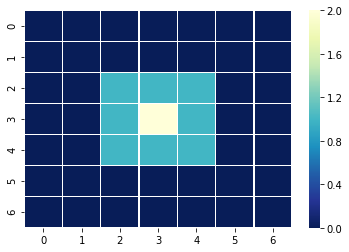

In [3]:
ca = CA(7, slope=0, time_limit=7, delta_water=0)

matrix = np.zeros((7, 7))
neighborhood, locations = ca.moore_neighborhood(matrix, 3, 3)

for location in locations:
    location = tuple(location)
    matrix[location] = 1

matrix[3, 3] = 2

sns.heatmap(matrix, linewidths=.5, cmap="YlGnBu_r")
plt.savefig(f'Moore_neighborhood.png', dpi=300)
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


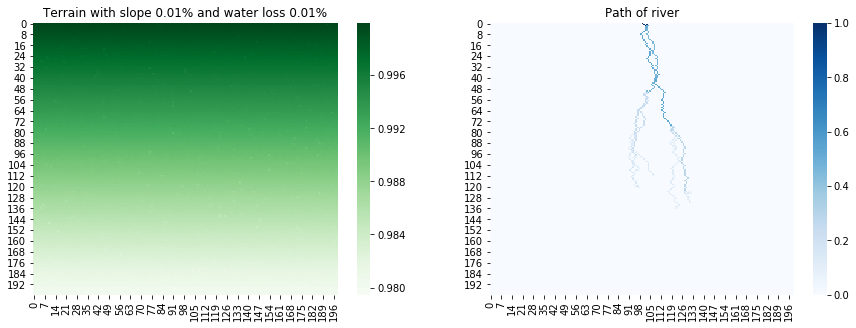

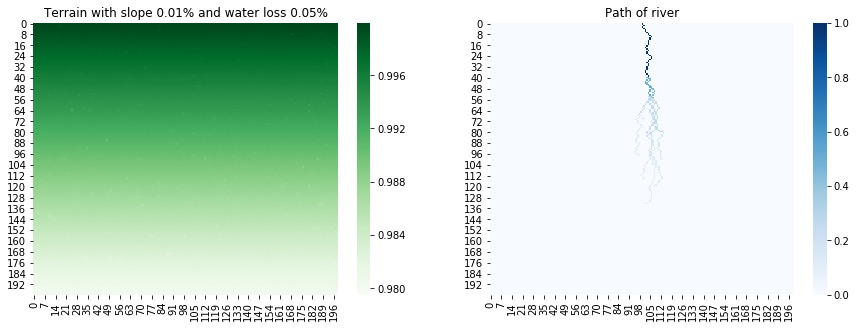

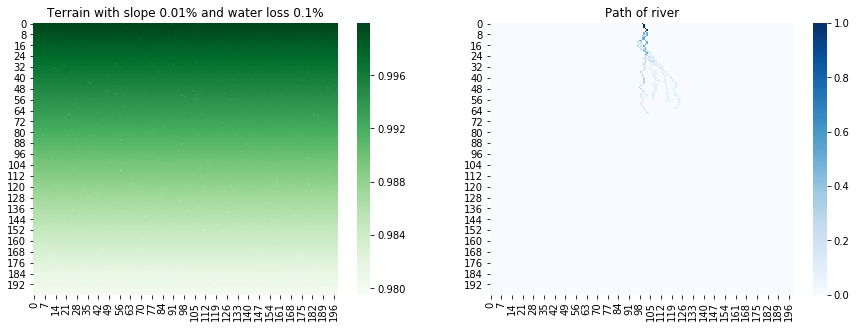

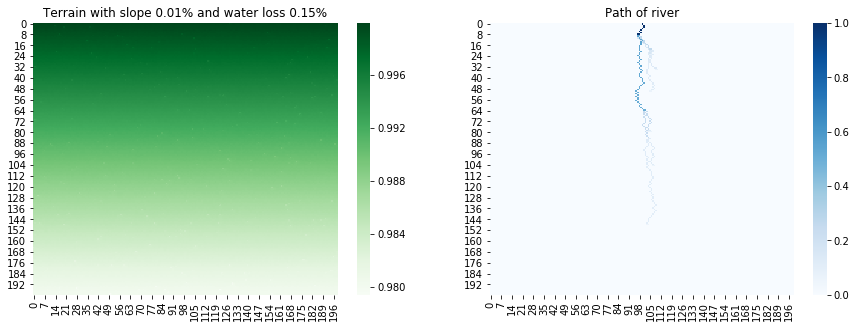

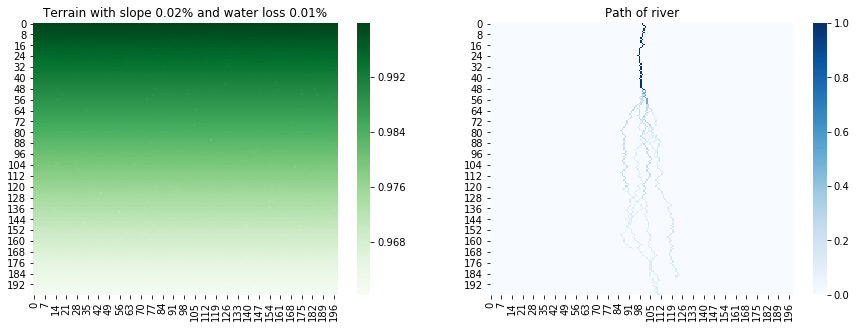

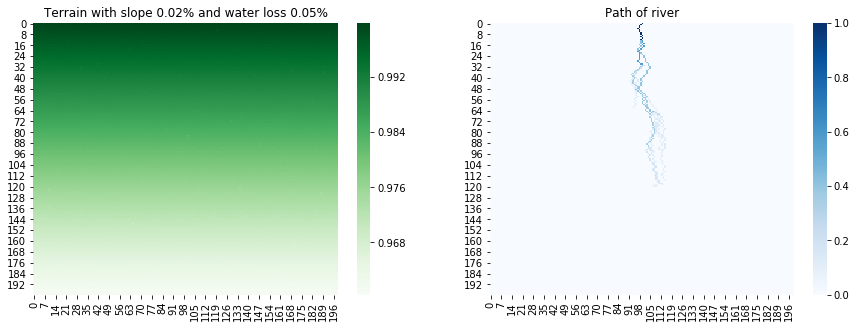

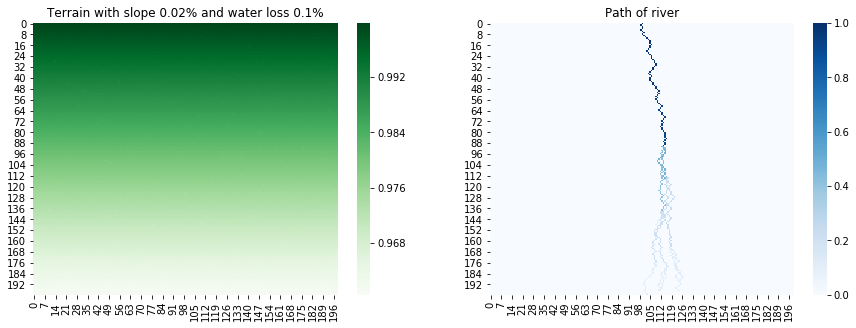

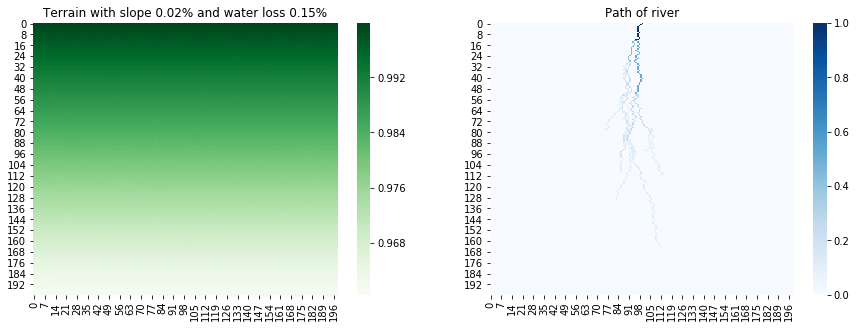

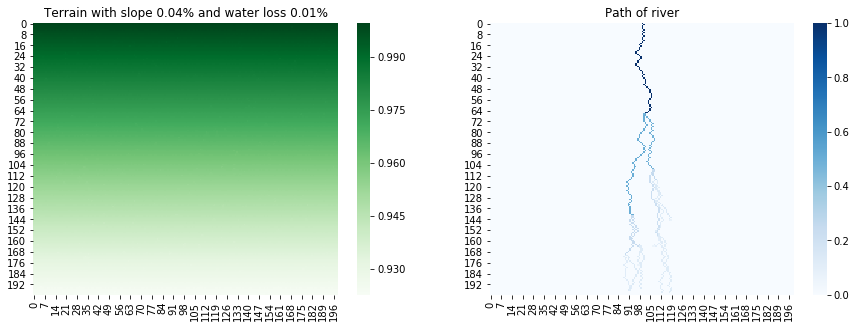

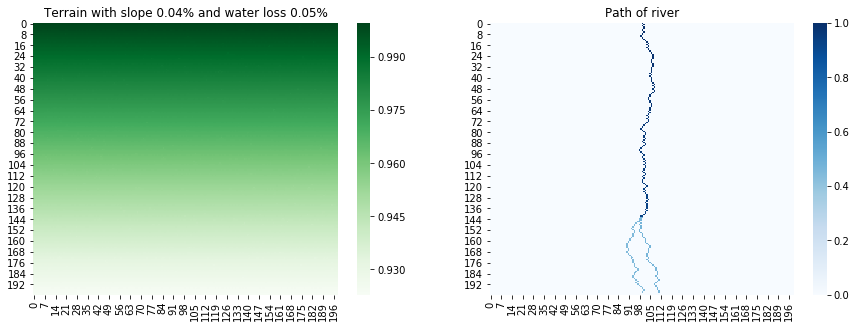

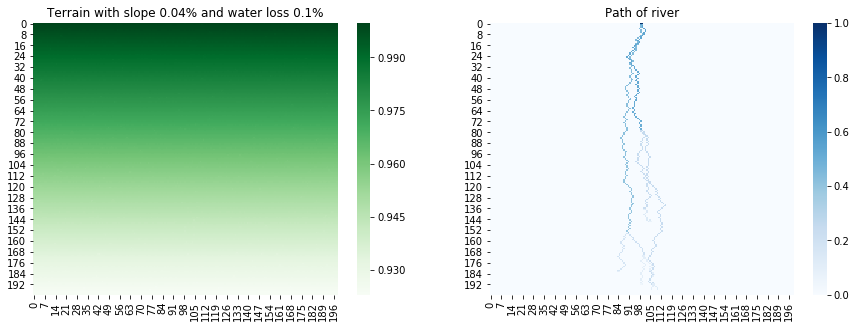

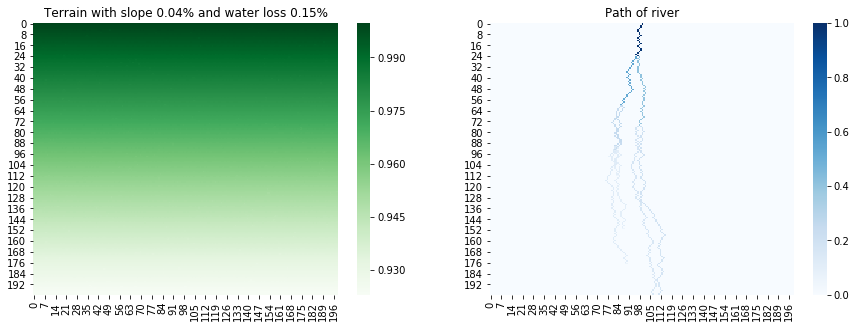

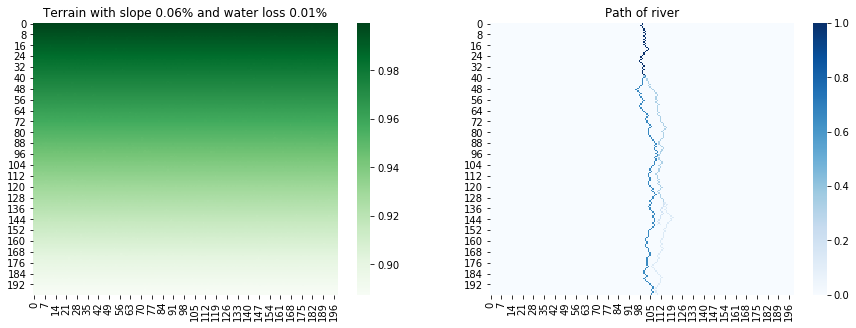

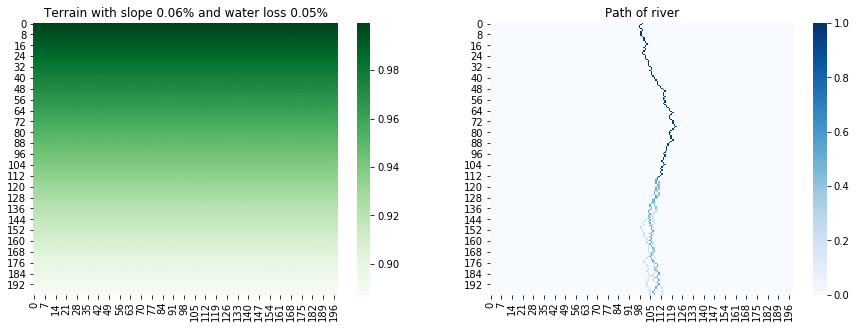

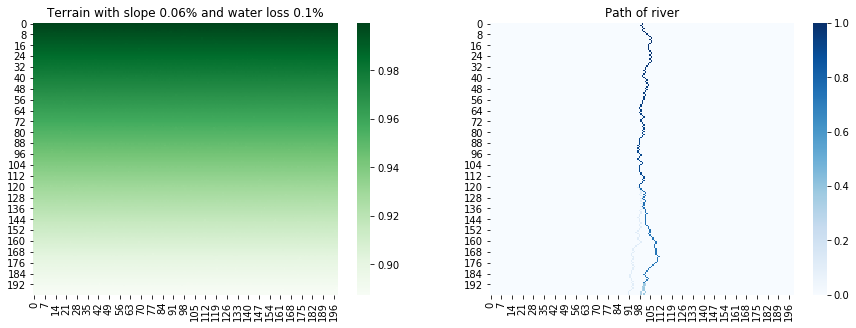

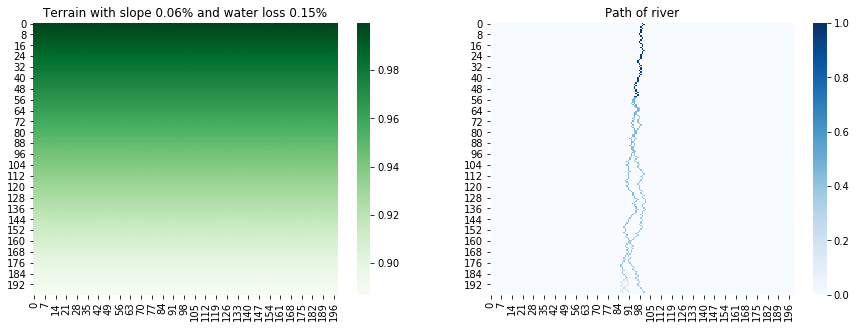

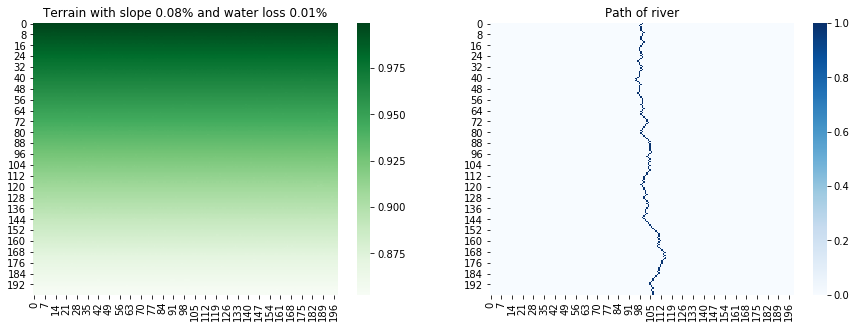

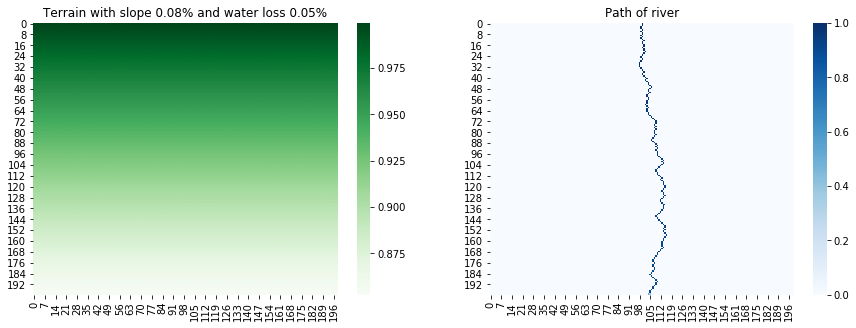

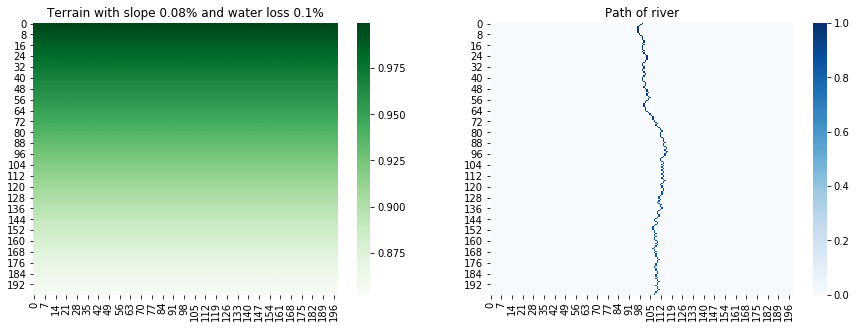

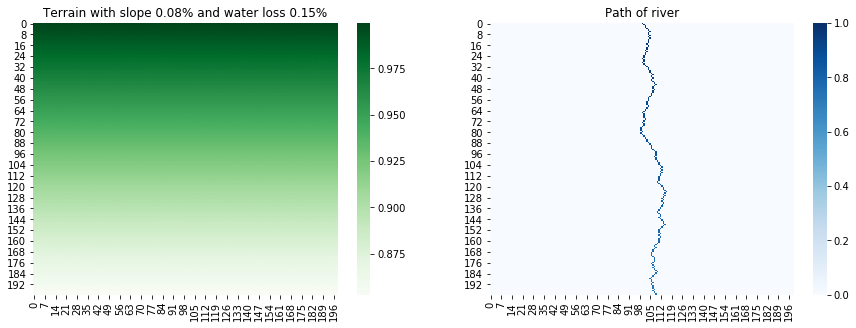

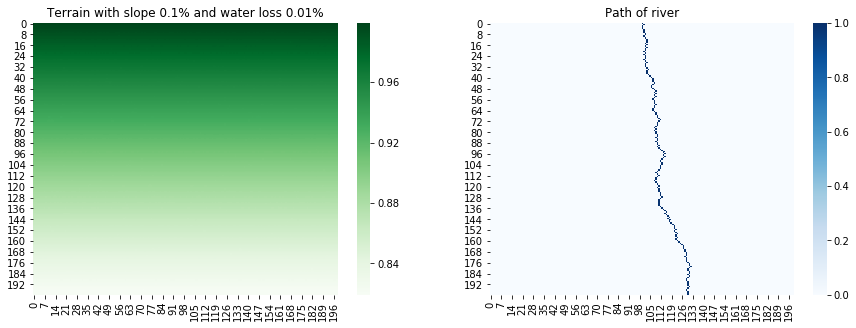

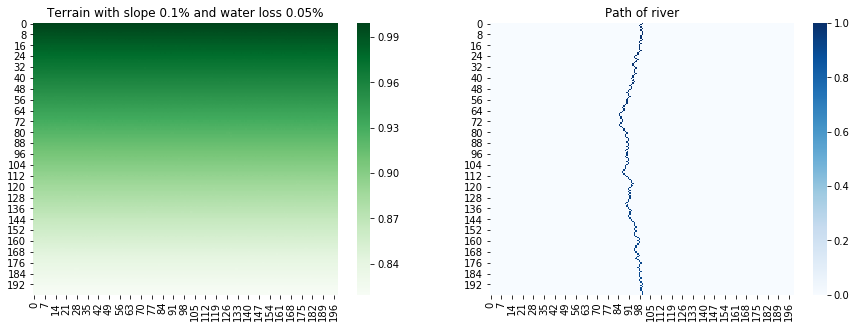

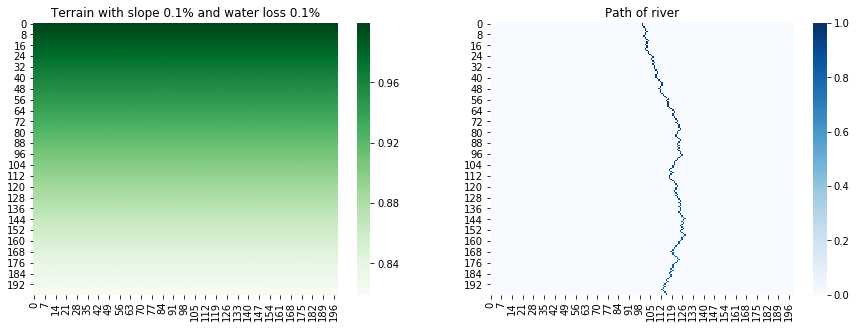

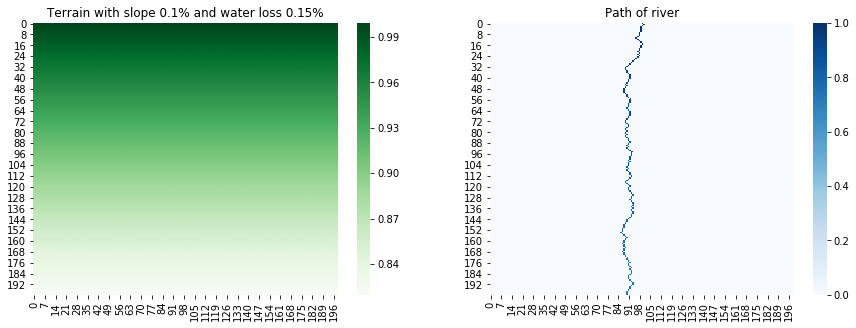

In [4]:
for i in range(1):
    size = 200
    slopes = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001]
    waters = [0.0001, 0.0005, 0.0010, 0.0015]
#     slopes = [0.0001]
#     waters = [0.0008]
    for slope in slopes:
        for water in waters:
            ca = CA(size=size, slope=slope, time_limit=size, delta_water=water)
            terrain = ca.initialize_terrain()
            path, segments, split_dict, segment_dict = ca.create_path_from_start()

            fig, axes = plt.subplots(1, 2,figsize=(15,5))

            sns.heatmap(terrain[:, 0:size-1], cmap="Greens", ax=axes[0])
            axes[0].set_title(f"Terrain with slope {slope*100}% and water loss {water*100}%")
            sns.heatmap(path, cmap="Blues", ax=axes[1])
            axes[1].set_title("Path of river")

0.0 1.0


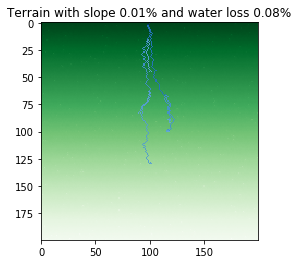

0.0 1.0


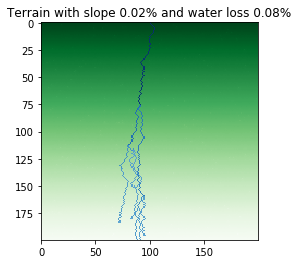

0.0 1.0


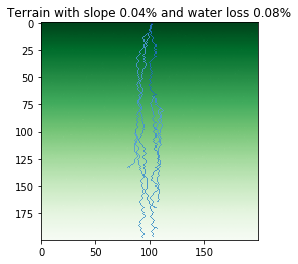

0.0 1.0


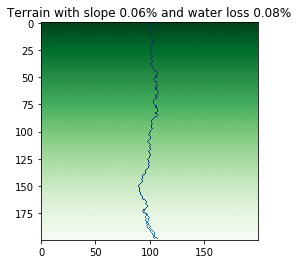

0.0 1.0


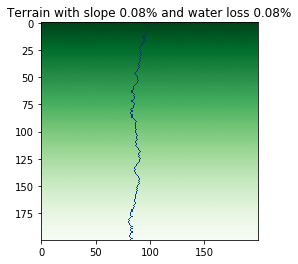

0.0 1.0


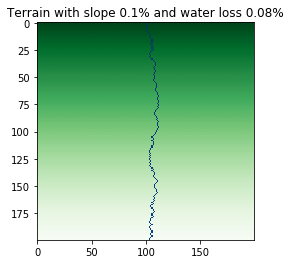

In [7]:
for i in range(1):
    size = 200
    slopes = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001]
    for slope in slopes:
        ca = CA(size=size, slope=slope, time_limit=size)
        terrain = ca.initialize_terrain()
        path, segments,_,_ = ca.create_path_from_start()

        # masked_data = np.random.random((100,100))
        masked_data = np.ma.masked_where(path < 0.01, path)
        print(np.min(path), np.max(path))
        # Overlay the two images
        fig, ax = plt.subplots()
        ax.imshow(terrain[:, 0:199], cmap='Greens')
        ax.imshow(masked_data, cmap='Blues',vmin=-1,vmax=1, interpolation='none')
        ax.set_title(f"Terrain with slope {slope*100}% and water loss 0.08%")
        plt.show()